In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim


In [2]:
input_path = "../content/DATA_CHAMBER_2021/"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -uq "/content/drive/My Drive/DATA_CHAMBER_2021.zip" -d "./"

In [5]:
class ImageFolderWithPaths(datasets.ImageFolder):

    # called by dataloaders
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [6]:
preprocess = {
    'train':
    transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize(32),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

image_datasets = {
    'train': 
    ImageFolderWithPaths(input_path + 'train', preprocess['train']),
    'validation': 
    ImageFolderWithPaths(input_path + 'test', preprocess['validation'])
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','validation']}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=2, pin_memory=True),
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=2, pin_memory=True)
}

In [7]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=False)
model.classifier[6] = nn.Linear(4096,3)
# fine tuning

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip


In [8]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [9]:
import torchvision
from torch.autograd import Variable
import time
from PIL import Image
from torchvision import transforms

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9)

In [11]:
# t0 = time.time()
# print('{} seconds'.format(time.time() - t0)
epochLine = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [12]:
def train_model(model, criterion, optimizer, num_epochs=1):
    train_batches = len(dataloaders['train'])
    lossLine = []
    accLine = []
    timeLine = []
    for epoch in range(num_epochs):
        print('-' * 40)
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 20)
        t0 = time.time()

        for phase in ['train']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            training_loss = 0.0
            training_corrects = 0

            for i,data in enumerate(dataloaders[phase]):
                inputs, labels,_ = data
                print("\rTraining batch {}/{}".format(i+1, train_batches), end='', flush=True)
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                # loss.requires_grad = True

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                training_loss += loss.item() * inputs.size(0)
                training_corrects += torch.sum(preds == labels.data)

            epoch_loss = training_loss / len(image_datasets[phase])
            lossLine.append(epoch_loss)
            epoch_acc = training_corrects.double() / len(image_datasets[phase])
            accLine.append(epoch_acc)

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            t1 = time.time()
            t = t1 - t0
            print('Duration :{} seconds'.format(t))
            ts = pd.DataFrame([t]).apply(np.float32)
            timeLine.append(ts)
    return model, lossLine, accLine, timeLine

In [13]:
model = model.to(device)
model_trained, lossLine, accLine, timeLine = train_model(model, criterion, optimizer, num_epochs=20)

----------------------------------------
Epoch 1/20
--------------------
Training batch 210/210train loss: 1.0974, acc: 0.3531
Duration :62.12159514427185 seconds
----------------------------------------
Epoch 2/20
--------------------
Training batch 210/210train loss: 1.0961, acc: 0.3603
Duration :61.99415826797485 seconds
----------------------------------------
Epoch 3/20
--------------------
Training batch 210/210train loss: 1.0953, acc: 0.3728
Duration :61.65939259529114 seconds
----------------------------------------
Epoch 4/20
--------------------
Training batch 210/210train loss: 1.0940, acc: 0.3850
Duration :62.17120051383972 seconds
----------------------------------------
Epoch 5/20
--------------------
Training batch 210/210train loss: 1.0907, acc: 0.4042
Duration :61.790955781936646 seconds
----------------------------------------
Epoch 6/20
--------------------
Training batch 210/210train loss: 1.0750, acc: 0.4305
Duration :61.58162045478821 seconds
---------------------

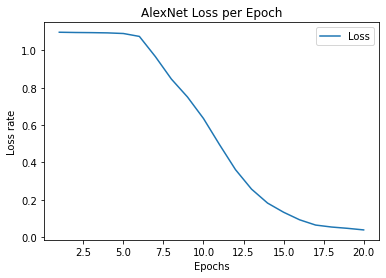

In [14]:
plt.plot(epochLine, lossLine, label="Loss")
plt.plot()

plt.xlabel("Epochs")
plt.ylabel("Loss rate")
plt.title("AlexNet Loss per Epoch")
plt.legend()
plt.show()

In [15]:
print(lossLine)

[1.0973907765913387, 1.0960543155670166, 1.0953007379386757, 1.093982164714598, 1.0906508602484788, 1.0750034533033985, 0.9665833086649435, 0.8462298834485384, 0.7506812544420608, 0.6353615183852978, 0.4955442477784662, 0.36109290718233655, 0.2568718565505087, 0.18212992748756113, 0.13305323911162206, 0.09249451443901263, 0.06427472804528679, 0.053656791185288266, 0.04667626482428886, 0.03824337688160294]


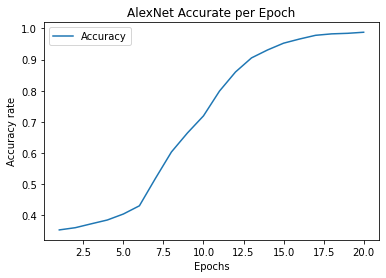

In [16]:
plt.plot(epochLine, accLine, label="Accuracy")
plt.plot()

plt.xlabel("Epochs")
plt.ylabel("Accuracy rate")
plt.title("AlexNet Accurate per Epoch")
plt.legend()
plt.show()

In [17]:
print(accLine)

[tensor(0.3531, device='cuda:0', dtype=torch.float64), tensor(0.3603, device='cuda:0', dtype=torch.float64), tensor(0.3728, device='cuda:0', dtype=torch.float64), tensor(0.3850, device='cuda:0', dtype=torch.float64), tensor(0.4042, device='cuda:0', dtype=torch.float64), tensor(0.4305, device='cuda:0', dtype=torch.float64), tensor(0.5184, device='cuda:0', dtype=torch.float64), tensor(0.6034, device='cuda:0', dtype=torch.float64), tensor(0.6644, device='cuda:0', dtype=torch.float64), tensor(0.7192, device='cuda:0', dtype=torch.float64), tensor(0.7989, device='cuda:0', dtype=torch.float64), tensor(0.8602, device='cuda:0', dtype=torch.float64), tensor(0.9055, device='cuda:0', dtype=torch.float64), tensor(0.9309, device='cuda:0', dtype=torch.float64), tensor(0.9527, device='cuda:0', dtype=torch.float64), tensor(0.9661, device='cuda:0', dtype=torch.float64), tensor(0.9780, device='cuda:0', dtype=torch.float64), tensor(0.9826, device='cuda:0', dtype=torch.float64), tensor(0.9844, device='cuda

In [18]:
total_time_train = 0
for i in timeLine:  total_time_train += i
print(total_time_train)

             0
0  1230.116455


In [25]:
def test_model(model, criterion, optimizer):
    labels_input=list()
    labels_output=list()
    vid_id = list()
    for phase in ['validation']:
        model.eval()

        for inputs, labels, fname in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_input= labels_input + labels.tolist()
            for f in fname:
                vid_id.append(f.split('/')[-1].split('.')[0].split('_')[0])
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            labels_output= labels_output + preds.tolist()
    return labels_input,labels_output,vid_id
            
y_true,y_pred,vid_id = test_model(model, criterion, optimizer)

In [26]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
print(classification_report(y_true,y_pred))
accuracy_score(y_true, y_pred)

              precision    recall  f1-score   support

           0       0.23      0.82      0.36       409
           1       0.00      0.00      0.00       367
           2       0.21      0.04      0.07       831

    accuracy                           0.23      1607
   macro avg       0.15      0.29      0.15      1607
weighted avg       0.17      0.23      0.13      1607



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.23148724331051648

In [29]:
df = pd.DataFrame(list(zip(y_true,y_pred,vid_id)),
               columns =['y_true','y_pred','vid_id'])
df.to_csv('df.csv',encoding='utf-8',index=False)

In [30]:
vid_list = list(set(df['vid_id'].values))

y_true = []
y_pred = []
for vid in vid_list:
    #print(vid)
    tmp_df = df[df['vid_id']==vid]
    #print(len(tmp_df))
    vid_pred = tmp_df['y_pred'].mode().values[0]
    vid_label = tmp_df['y_true'].mode().values[0]
    y_true.append(vid_label)
    y_pred.append(vid_pred)
    #print(vid_label,"\n",vid_pred)
    
    print('vid: {} label: {} pred: {}'.format(vid,vid_label,vid_pred))


vid: 163 label: 0 pred: 0
vid: 159 label: 0 pred: 0
vid: 184 label: 2 pred: 0
vid: 160 label: 0 pred: 0
vid: 185 label: 1 pred: 0
vid: 170 label: 2 pred: 0
vid: 158 label: 2 pred: 0
vid: 169 label: 0 pred: 0
vid: 193 label: 1 pred: 0
vid: 186 label: 0 pred: 0
vid: 188 label: 1 pred: 0
vid: 173 label: 1 pred: 2
vid: 187 label: 0 pred: 0
vid: 164 label: 2 pred: 0
vid: 176 label: 0 pred: 0
vid: 181 label: 0 pred: 0
vid: 192 label: 2 pred: 0
vid: 191 label: 0 pred: 0
vid: 171 label: 0 pred: 2
vid: 190 label: 1 pred: 0
vid: 177 label: 1 pred: 0


In [23]:
accuracy_score(y_true,y_pred)

0.28205128205128205